In [119]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import os
# os.chdir('/home/jiageng/Documents/fhr/pipeline/')
os.chdir('/home/jiageng/Documents/fhr/pygcn/pygcn')
import snf
from sklearn.feature_selection import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.linear_model import *

In [12]:
def stdNormalize(df):
    std = df.std().fillna(1)
    mean = df - df.mean()
    df_norm = mean / std
    return df_norm

In [4]:
def rowNormalize(mx):
    """Row-normalize matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = np.diag(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [5]:
from scipy.sparse import coo_matrix

def sparse_tensor_from_arr(arr):
    """Convert numpy array to torch sparse tensor"""
    # Convert numpy array to scipy sparse matrix
    sparse_sp = coo_matrix(arr)
    
    # Convert scipy sparse matrix to torch sparse tensor
    sparse_tensor = torch.sparse_coo_tensor(
        torch.LongTensor([sparse_sp.row, sparse_sp.col]),
        torch.FloatTensor(sparse_sp.data),
        torch.Size(sparse_sp.shape)
    )
    
    return sparse_tensor

Prepare labels

In [6]:
fhr_data = pd.read_csv('/home/jiageng/Documents/fhr/annotations/fhr-annotations.tsv',sep='\t').set_index('PUBLIC_ID').query('risk != -1')
fhr_data['risk'] += 1

Prepare features

In [7]:
# subset to samples with fhr labels
cnmat = pd.read_csv('/home/jiageng/Documents/fhr/matrices/gene_cn_matrix.tsv.gz',sep='\t').set_index('PUBLIC_ID')
if 'SAMPLE' in cnmat.columns:
    cnmat = cnmat.drop(columns=['SAMPLE'])

In [15]:
labeled_ids = list(set(fhr_data.index).intersection(set(cnmat.index)))
print(len(labeled_ids))

864


Prepare X and y for feature selection

In [55]:
Xfull = stdNormalize(cnmat)
X = Xfull.loc[labeled_ids]
y = fhr_data.loc[labeled_ids,'risk']
print(Xfull.shape) # useful for unsupervised feature selection
print(X.shape)
print(y.shape)

(924, 18787)
(864, 18787)
(864,)


In [18]:
mifo = mutual_info_classif(X, y)

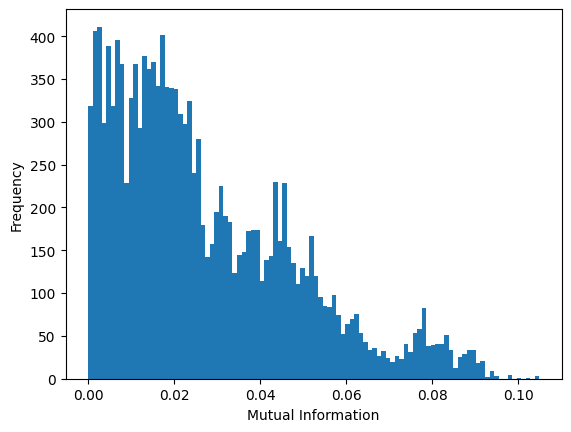

In [19]:
import matplotlib.pyplot as plt

plt.hist(mifo[mifo>0], bins=100)
plt.xlabel('Mutual Information')
plt.ylabel('Frequency')
plt.show()

In [26]:
anovaf = f_classif(X, y)

In [30]:
anovaf[1]

array([9.03098029e-01, 8.76857160e-01, 7.20962088e-01, ...,
       4.38978525e-13, 8.67075088e-16, 1.18677722e-13], shape=(18787,))

In [72]:
varthresh = VarianceThreshold(0)
varthresh.fit(cnmat)
len(varthresh.get_feature_names_out())

18787

In [73]:
varthresh.variances_

array([0.04561113, 0.0477006 , 0.04291145, ..., 0.10744785, 0.1118324 ,
       0.12060801], shape=(18787,))

Family wise error rate significance threshold of 0.05

In [87]:
fwe = SelectFwe(f_classif, alpha=0.05)
fwe.fit(X, y)
sum(fwe.get_support())

np.int64(6492)

In [ ]:
Xfwe = fwe.fit_transform(X, y)
print(Xfwe.shape)

(864, 6492)


False discovery rate significance threshold of 0.05

In [88]:
fdr = SelectFdr(f_classif, alpha=0.05)
fdr.fit(X, y)
sum(fdr.get_support())

np.int64(12248)

False positive rate test significance threshold of 0.05

In [89]:
fpr = SelectFpr(f_classif, alpha=0.05)
fpr.fit(X, y)
sum(fpr.get_support())

np.int64(12790)

In [90]:
cn_scores = pd.DataFrame({'gid':cnmat.columns, 
                          'variance':varthresh.variances_,
                          'mutual_info':mifo, 
                          'anova_f': anovaf[0],
                          'anova_p': anovaf[1],
                          'fwe_alpha_5e2':fwe.get_support(),
                          'fdr_alpha_5e2':fdr.get_support(),
                          'fpr_alpha_5e2':fpr.get_support(),
                         })
cn_scores.to_csv('../../scores/gene_cn_scores.tsv',sep='\t',index=False)

Perform recusrive feature elimination starting from the top X features

In [151]:
top_indices = np.argsort(anovaf[1])[:500]
Xtop = X.iloc[:,top_indices]
print(Xtop.shape)

(864, 500)


Use SVM as base estimator

In [153]:
estimator = SVC(kernel="linear") # only linear kernel allows feature imporance
rfecv = RFECV(estimator, step=10, cv=3)
rfecv.fit(Xtop, y)

RFECV(cv=3, estimator=SVC(kernel='linear'), step=10)

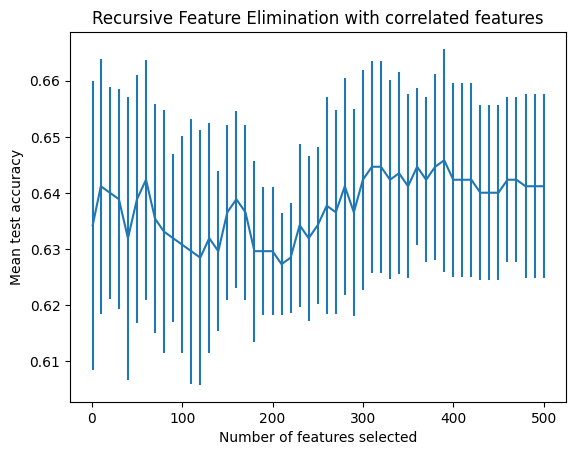

In [159]:
cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination with correlated features")
plt.savefig('../../assets/rfecv_results_gene_cn.png')
plt.show()

In [160]:
ensgid = pd.read_csv('/home/jiageng/Documents/fhr/annotations/ensgid-autosomal-proteincoding.txt',sep='\t').set_index('Gene stable ID')

In [164]:
ensgid.loc[Xtop.iloc[:,rfecv.support_].columns].groupby(['Chromosome/scaffold name']).value_counts()

Chromosome/scaffold name  Gene name  Gene start (bp)  Gene end (bp)
1                         ACKR1      159204875        159206500        1
                          ACP6       147629652        147670524        1
                          ADAMTSL4   150549369        150560937        1
                          ADAR       154581695        154628013        1
                          ADCY10     167809386        167914215        1
                                                                      ..
13                        TSC22D1    44432143         44577147         1
                          UBL3       29764371         29850617         1
                          UFM1       38349849         38363619         1
                          VWA8       41566835         41961120         1
                          WBP4       41061509         41084006         1
Name: count, Length: 383, dtype: int64

In [165]:
ensgid.loc[Xtop.iloc[:,rfecv.support_].columns].groupby(['Chromosome/scaffold name']).size()

Chromosome/scaffold name
1     324
13     66
dtype: int64

In [155]:
rfecv.n_features_

np.int64(390)

In [108]:
estimator = SVC(kernel="linear") # only linear kernel allows feature imporance
rfecv = RFECV(estimator, step=0.1, cv=5)
rfecv.fit(Xtop, y)

RFECV(cv=5, estimator=SVC(kernel='linear'), step=0.1)

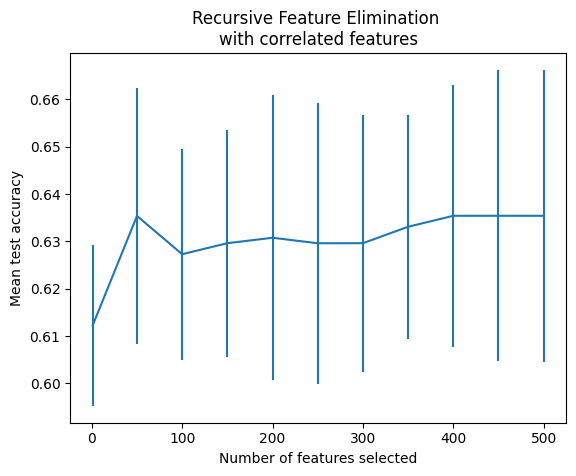

In [109]:
import matplotlib.pyplot as plt
import pandas as pd

cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

Use tree as base estimator

In [115]:
estimator = DecisionTreeClassifier() # the estimator needs to have coef_ or feature_importance_
rfecv = RFECV(estimator, step=0.1, cv=10)
rfecv.fit(Xtop, y)

RFECV(cv=10, estimator=DecisionTreeClassifier(), step=0.1)

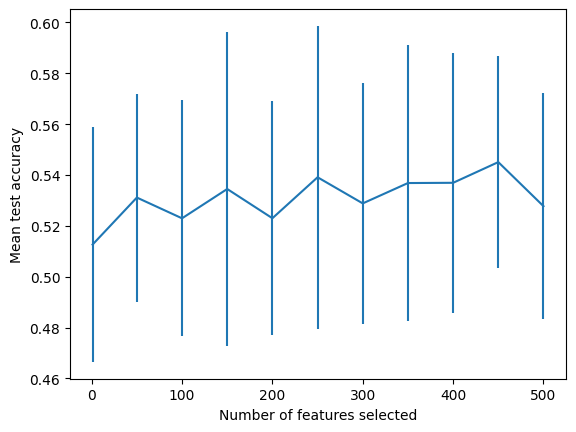

In [116]:
cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.show()

Use linear models as base estimator. This should be the final choice

In [134]:
estimator = SGDClassifier() # the estimator needs to have coef_ or feature_importance_
rfecv = RFECV(estimator, step=0.05, cv=3)
rfecv.fit(Xtop, y)

RFECV(cv=3, estimator=SGDClassifier(), step=0.05)

In [136]:
cv_results

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,n_features
0,0.587963,0.008661,0.590278,0.576389,0.597222,1
1,0.498843,0.180652,0.659722,0.590278,0.246528,10
2,0.445602,0.208975,0.538194,0.642361,0.156250,20
3,0.479167,0.167124,0.652778,0.531250,0.253472,30
4,0.508102,0.180563,0.673611,0.256944,0.593750,40
5,0.563657,0.040127,0.506944,0.593750,0.590278,50
6,0.633102,0.021467,0.663194,0.621528,0.614583,60
7,0.508102,0.185503,0.656250,0.246528,0.621528,70
8,0.508102,0.175964,0.652778,0.260417,0.611111,80
9,0.509259,0.173619,0.666667,0.267361,0.593750,90


In [149]:
ensgid = pd.read_csv('/home/jiageng/Documents/fhr/annotations/ensgid-autosomal-proteincoding.txt',sep='\t').set_index('Gene stable ID')

In [150]:
ensgid.loc[Xtop.iloc[:,rfecv.support_].columns]

,Gene name,Chromosome/scaffold name,Gene start (bp),Gene end (bp)
ENSG00000187800,PEAR1,1,156893698,156916429
ENSG00000160838,LRRC71,1,156920632,156933094
ENSG00000027644,INSRR,1,156840063,156859117
ENSG00000143621,ILF2,1,153661788,153671028
ENSG00000143553,SNAPIN,1,153658703,153661852
ENSG00000196420,S100A5,1,153537147,153541765
ENSG00000178096,BOLA1,1,149887890,149900798
ENSG00000014914,MTMR11,1,149928651,149936879
ENSG00000159164,SV2A,1,149903318,149917844
ENSG00000143368,SF3B4,1,149923317,149927803


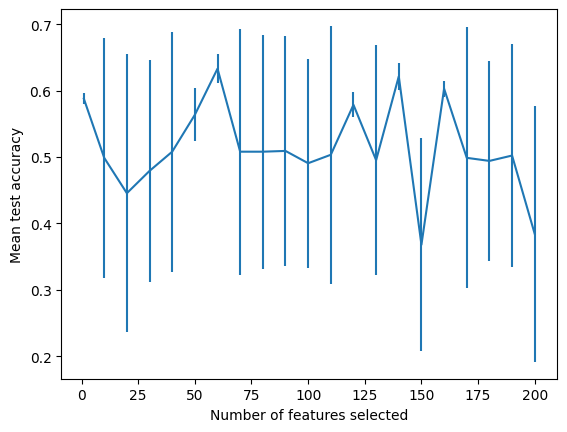

In [135]:
cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.show()

What this implies is that the best signal comes from the copy number of 1q as a whole.